In [1]:
# importing the libraries
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('ggplot')

In [2]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("train.csv")

# Read CSV test data file into DataFrame
test_df = pd.read_csv("test.csv")

# preview train data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


Uwaga: w danych testowych nie ma zmiennej docelowej (tj. Brakuje kolumny "Survival"), więc celem jest przewidzenie tego celu za pomocą różnych algorytmów uczenia maszynowego, takich jak regresja logistyczna.

## Data preprocessing

In [4]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# percent of missing "Age" 
print((train_df['Age'].isnull().sum()/train_df.shape[0])*100)

19.8653198653


Brakuje 20% wpisów dotyczących wieku pasażera. Zobaczmy, jak wygląda zmienna "Age".

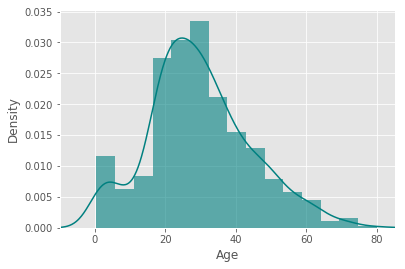

In [6]:
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Ponieważ rozkład "Age" jest (prawo) skośny, użycie średniej może dać nam stronnicze wyniki, wypełniając Age starsze niż pożądane. Aby poradzić sobie z tym, użyjemy mediany do przypisania brakujących wartości.

In [7]:
# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))

The mean of "Age" is 29.70
The median of "Age" is 28.00


In [8]:
# percent of missing "Cabin" 
print((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100)

77.1043771044


Brakuje 77% rekordów, co oznacza, że przypisywanie informacji i używanie tej zmiennej do przewidywania prawdopodobnie nie jest mądre. Zignorujemy tę zmienną w naszym modelu.

In [9]:
# percent of missing "Embarked" 
print((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100)

0.224466891134


Są tylko 2 (0,22%) brakujące wartości dla "Embarked", więc możemy tutaj przypisać najpopularniejszy port.

Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


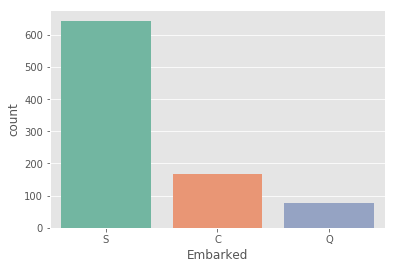

S


In [10]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()
print(train_df['Embarked'].value_counts().idxmax())

## Uzupełnianie danych
Na podstawie oceny brakujących wartości w zbiorze danych wprowadzimy następujące zmiany w danych:

- Jeśli w danym wierszu brakuje "Age", przypiszemy mu 28 (średni wiek).
- Jeśli "Embarked" nie ma w rzędzie, przypisuję mu "S" (najczęstszy port wejścia na pokład).
- Zignorujemy "Cabin" jako zmienną. Jest zbyt wiele brakujących wartości. W oparciu o dostępne informacje okazuje się, że wartość ta jest związana z klasą pasażera i zapłaconą taryfą.

In [11]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [12]:
# check missing values in adjusted train data
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [13]:
# preview adjusted train data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Additional Variables

Według słownika danych Kaggle, zarówno SibSp, jak i Parch odnoszą się do podróżowania z rodziną. Dla uproszczenia (i biorąc pod uwagę możliwą wieloklinowość), połączę wpływ tych zmiennych na jeden kategoryczny predyktor: niezależnie od tego, czy osoba podróżowała sama. Stworzymy również zmienne kategoryczne dla klasy pasażera ("Pclass"), płci ("Sex") i portu Embarked ("Zaokrętowany").

In [14]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

In [16]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"], drop_first = True)
training.drop('Name', axis=1, inplace=True)

final_train = training
final_train.head()

,PassengerId,Survived,Age,Ticket,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,1,0,22.0,A/5 21171,7.2500,0,0,1,0,1,1
1,2,1,38.0,PC 17599,71.2833,0,0,0,0,0,0
2,3,1,26.0,STON/O2. 3101282,7.9250,1,0,1,0,1,0
3,4,1,35.0,113803,53.1000,0,0,0,0,1,0
4,5,0,35.0,373450,8.0500,1,0,1,0,1,1


Teraz zastosujemy te same zmiany w danych testowych. Dla wieku przypiszemy średnią równą 28. Zignorujemy Kabinę. Dla zmiennej "Emabrked" nic nie musimy robić.

In [40]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [17]:
test_data = test_df.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"], drop_first = True)
testing.drop('Name', axis=1, inplace=True)

final_test = testing
final_test.head()

,PassengerId,Age,Ticket,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,892,34.5,330911,7.8292,1,0,1,1,0,1
1,893,47.0,363272,7.0000,0,0,1,0,1,0
2,894,62.0,240276,9.6875,1,1,0,1,0,1
3,895,27.0,315154,8.6625,1,0,1,0,1,1
4,896,22.0,3101298,12.2875,0,0,1,0,1,0


In [18]:
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

## Feature selection

Biorąc pod uwagę zewnętrzny estymator, który przypisuje wagi do funkcji, rekursywna eliminacja cech (RFE) polega na wybieraniu cech poprzez rekurencyjne uwzględnianie coraz mniejszych zestawów cech. Po pierwsze, estymator jest przeszkolony w zakresie początkowego zestawu funkcji, a ważność każdej cechy jest uzyskiwana za pomocą atrybutu coef_ lub atrybutu feature_importances_. Następnie, najmniej ważne funkcje są przycinane z bieżącego zestawu funkcji. Ta procedura jest powtarzana rekursywnie na oczyszczonym zestawie, aż ostatecznie osiągnięta zostanie wymagana liczba funkcji do wybrania.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


RFECV wykonuje RFE w pętli sprawdzania krzyżowego, aby znaleźć optymalną liczbę lub najlepszą liczbę funkcji. Odtąd rekurencyjna eliminacja cech stosowana w regresji logistycznej z automatycznym dostosowaniem liczby funkcji wybranych za pomocą sprawdzania krzyżowego.

Optimal number of features: 8
Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


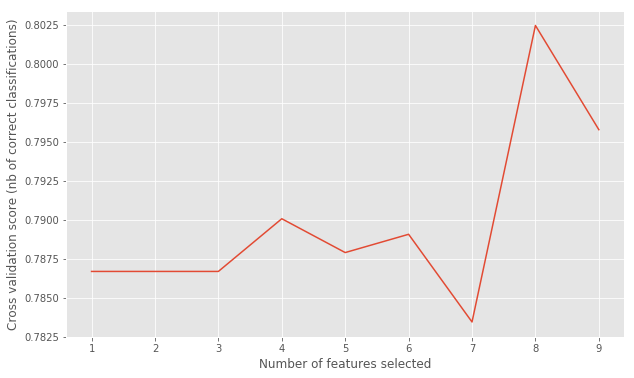

In [49]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Jak widzimy, zachowano osiem zmiennych.

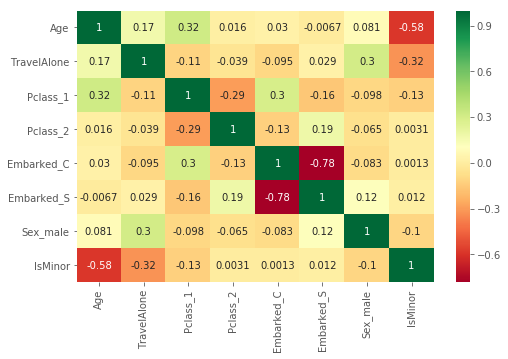

In [51]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

## Logistic Regression

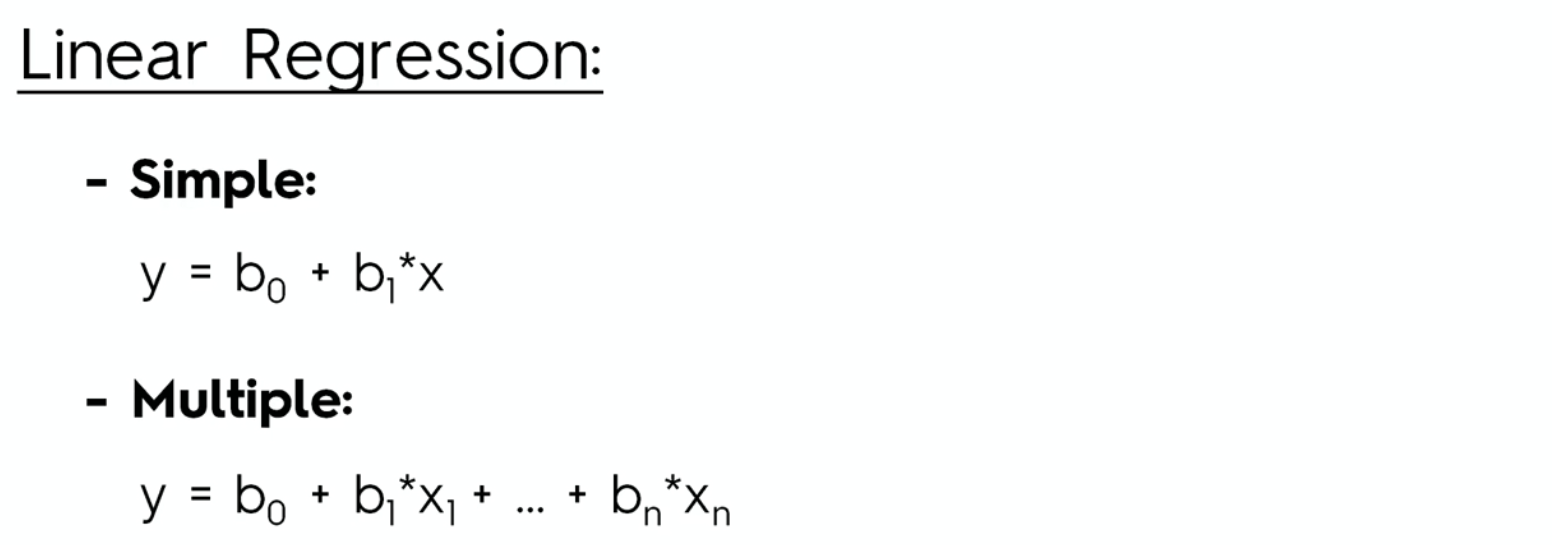

In [58]:
from IPython.display import Image
Image(filename='Logistic1.PNG')

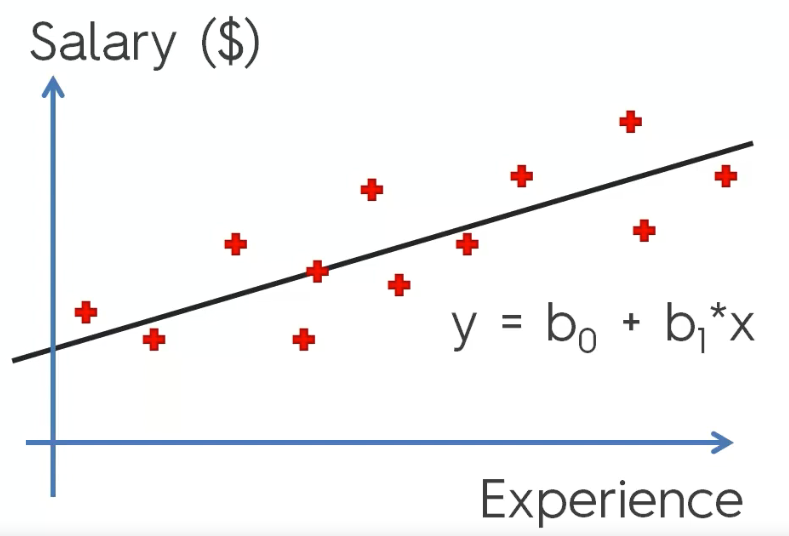

In [60]:
Image(filename='Logistic2.PNG')

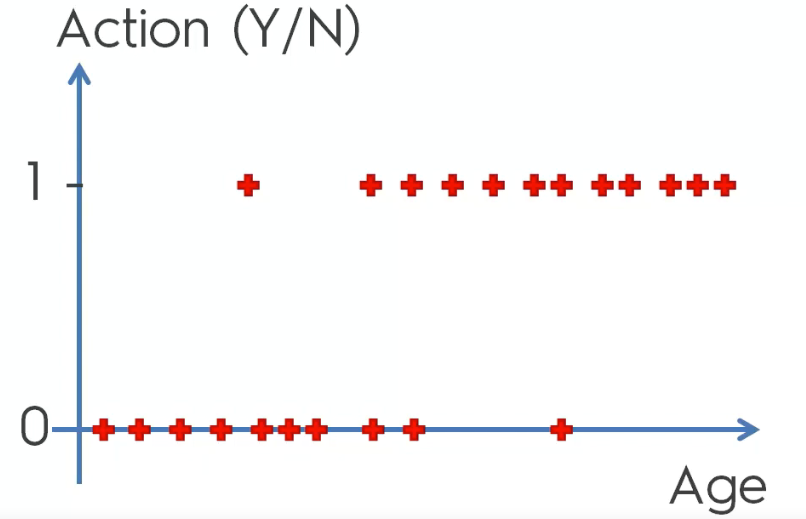

In [61]:
Image(filename='Logistic3.PNG')

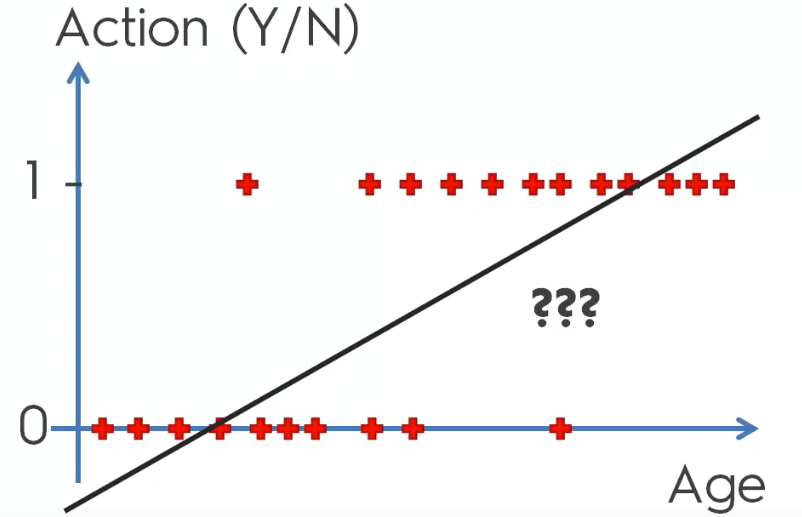

In [62]:
Image(filename='Logistic4.PNG')

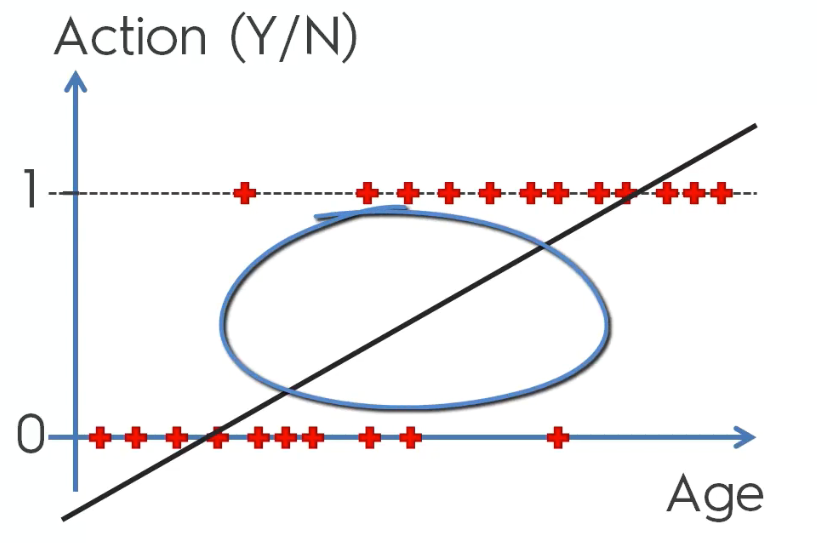

In [63]:
Image(filename='Logistic5.PNG')

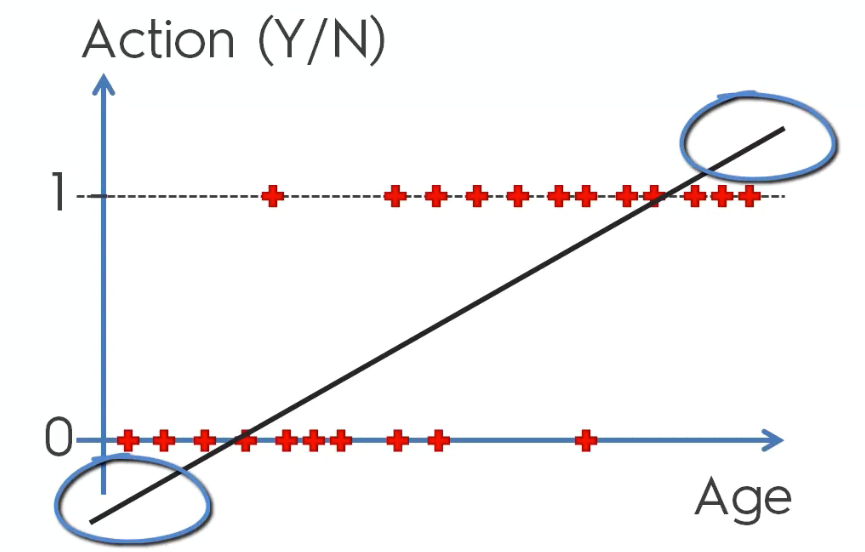

In [64]:
Image(filename='Logistic6.PNG')

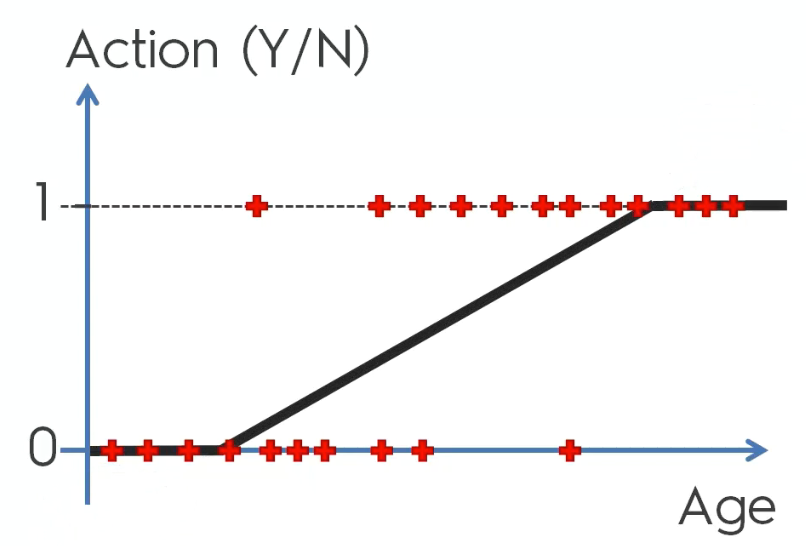

In [65]:
Image(filename='Logistic7.PNG')

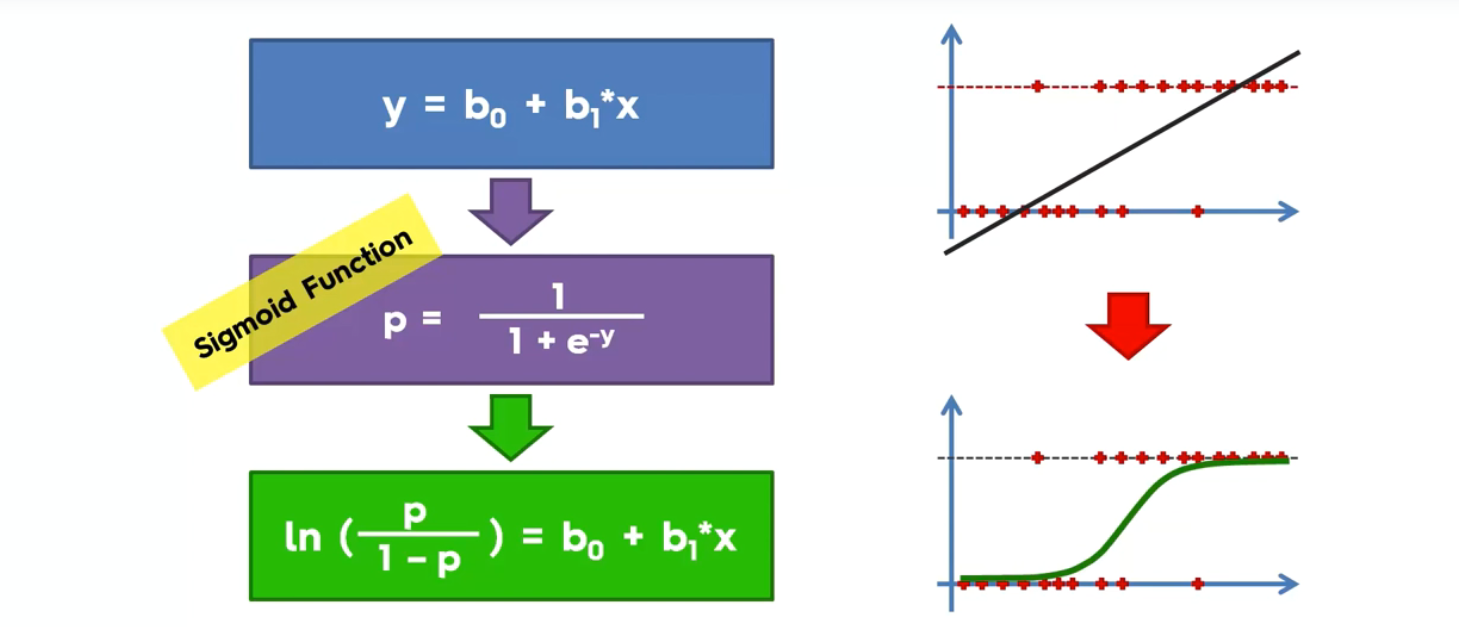

In [66]:
Image(filename='Logistic8.PNG')

Train/Test split results:
LogisticRegression accuracy is 0.782
LogisticRegression log_loss is 0.504
LogisticRegression auc is 0.839


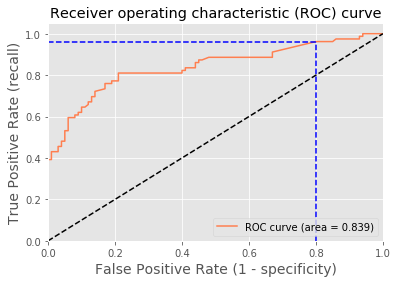

Using a threshold of 0.071 guarantees a sensitivity of 0.962 and a specificity of 0.200, i.e. a false positive rate of 80.00%.


In [54]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)
X = final_train[Selected_features]
y = final_train['Survived']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

Source: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python/notebook